In [167]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import re
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками
from sklearn import preprocessing


In [224]:
hotels = pd.read_csv('data\hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [169]:
#поиск пропущенных значений, числовых данных
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

1. в дальнейшем нужно преобразовать дату из object в дату
2. пробразовать days_since review в число
3. выполнить кодирование категориальных признаков
4. проанализировать адрес, название и отзывы на выделение полезных признаков для модели. 

# Строим первую простейшую модель

In [170]:
#удаляем нечисловые столбцы
hotels1=hotels.drop(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review'],axis = 1)

In [171]:
#заполняем пропуска
hotels1['lat'] = hotels1['lat'].fillna(hotels1['lat'].mean())
hotels1['lng'] = hotels1['lng'].fillna(hotels1['lng'].mean())

In [172]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels1.drop(['reviewer_score'], axis = 1)  
y = hotels1['reviewer_score'] 

In [173]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [174]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [175]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [176]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14137124912493818


Небольшой бонус:


In [177]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)

# EDA для получения лучшей модели

## Выполнение заданий в модуле

In [225]:
# 4.2 подсчитаем уникальные названия отелей
hotels['hotel_name'].nunique()

1492

In [226]:
#4.3 работа с датой отзывов
#сделаем преобразование в дату
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
print('Самый ранний отзыв: ', hotels['review_date'].min())
print('Самый поздний отзыв: ', hotels['review_date'].max())

Самый ранний отзыв:  2015-08-04 00:00:00
Самый поздний отзыв:  2017-08-03 00:00:00


In [227]:
#4.4 количество тегов
def tags_list(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res
hotels_test = hotels.copy()
hotels_test['tags_n'] = hotels_test['tags'].apply(tags_list)
hotels_test = hotels_test.explode('tags_n')
tags_res = hotels_test['tags_n'].value_counts()
print('Количество тегов: ', len(tags_res))


Количество тегов:  2368


In [228]:
#4.5 самый частый тег
print(tags_res)

Leisure trip                         313593
Submitted from a mobile device       230778
Couple                               189212
Stayed 1 night                       145373
Stayed 2 nights                      100263
                                      ...  
Studio with Spa Access                    1
Comfort Family Room                       1
Junior Suite Free Wifi                    1
Design Suite                              1
Executive Double Room Non Smoking         1
Name: tags_n, Length: 2368, dtype: int64


## Работа с датой (номер недели, месяц, диаграмма месяц от времени года)

Мы не можем в модели использовать просто дату. поэтому попробуем выделить из нее полезную информацию, которую сможем использовать.  
Так как по правилам букинга разместить отзыв можно близко к дате поездки, то можно считать, что дата отзыва совпадает с временем поездки. Нас интересует месяц поездки, так как в разные месяцы наблюдается разное количество туристов, разные мероприятия, разная погода. Предполагаю, что время поездки (сезон) влияют на рейтинг.
Выделим месяц и неделю - это признаки, которые характеризуют сезон. 

In [229]:
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_week'] = hotels['review_date'].dt.isocalendar().week

Посмотрим есть ли зависимость между месяцем отзыва и оценкой

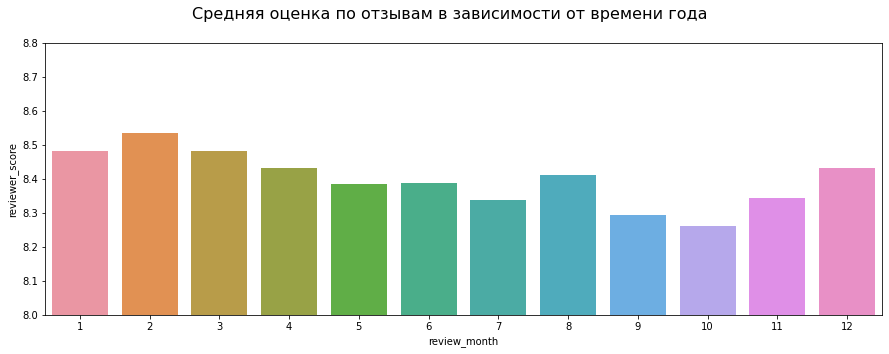

In [230]:
pivot_month = hotels[['review_month', 'reviewer_score']].groupby(
    'review_month').mean()
fig = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от времени года', size=16)
bar_month = sns.barplot(
    x=pivot_month.index, 
    y=pivot_month['reviewer_score'])
plt.ylim(8, 8.8);
 

Мы видим, что есть определенная зависимость месяца помещения и оценки.

Так же у нас есть еще один показатель, связанный с датой - days_since_review. преобразуем его в число.

In [231]:
# Преобразуем признак 'days_since_review' в числовой вид
def to_integer(x):
    a = x.split()
    return np.int64(a[0])

hotels['days_since_review'] = hotels['days_since_review'].apply(to_integer)

## Категориальные признаки

Категориальными признаками являются:
1. hotel_address 
2. hotel_name 
3. reviewer_nationality
4. negative_review 
5. positive_review
6. tags
эти признаки нам нужно проанализировать и преобразовать.

Начнем с проверки количество различных имен отелей и их адресов. 

In [232]:
# Найдем число учавствующих отелей и их адресов (должны совпадать)
print('Число адресов отелей: ', hotels['hotel_address'].nunique())
print('Число названий отелей: ', hotels['hotel_name'].nunique())

Число адресов отелей:  1493
Число названий отелей:  1492


Видимо один из отелей имеет два адреса, но имеет одинаковое название. пока оставим эту информацию, позже посмотрим влияние признака на результат. 
можно еще посмотреть топ отелей по отзывам (так как малое число отзывов сильно влияет на оценку, то возьмем порог в 100 отзывов для отбора и далее выберем отзывы с максимальными оценками)

In [233]:
hotels_names = hotels.groupby('hotel_name')['average_score'].agg(
    ['mean', 'count'])

mask = (hotels_names['mean'] >= 9.0) & (hotels_names['count'] >= 100)
hotels_top = hotels_names[mask]

print('Лучшие по отзывам отели, имеющие минимум 100 отзывов:')

display(hotels_top)


Лучшие по отзывам отели, имеющие минимум 100 отзывов:


,mean,count
hotel_name,,
Acad mie H tel Saint Germain,9.0,192
Alma Barcelona GL,9.2,136
Amba Hotel Charing Cross,9.3,581
Ambassade Hotel,9.3,437
Andaz Amsterdam Prinsengracht A Hyatt Hotel,9.3,157
...,...,...
Waldorf Astoria Amsterdam,9.5,108
art otel Amsterdam,9.0,603
citizenM London Bankside,9.1,1135


Мы видим, что даже отелей с высокими оценками большим числом отзывов больше 100, посмотрим еще при оценки значимости признаков влияние названия, н я склоняюсь к удалению этого признака без кодирования, чтобы не раздувать объем данных. 

Теперь внимательно посмотрим на адреса: мы можем выделить из них страну и город, что пригодиться для дальнейшего анализа

In [234]:
addresses = hotels['hotel_address'].unique()
display(addresses)

array(['Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom',
       '130 134 Southampton Row Camden London WC1B 5AF United Kingdom',
       '151 bis Rue de Rennes 6th arr 75006 Paris France', ...,
       'Prinsengracht 717 Amsterdam City Center 1017 JW Amsterdam Netherlands',
       '43 Rue De l Abb Gr goire 6th arr 75006 Paris France',
       'Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria'],
      dtype=object)

In [235]:
# Выделим признак страны из адреса
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x:
    'United Kingdom' if x.split(sep=' ')[-1] == 'Kingdom' else x.split(sep=' ')[-1])

# Выделим признак города из адреса
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x:
    'London' if x.split()[-2] == 'United' else x.split()[-2])

In [236]:
# есть ли отели из разных городов по странам
addresses_pivot = pd.pivot_table(hotels, values ='hotel_address', index ='hotel_country', columns='hotel_city', aggfunc='count')  
display(addresses_pivot)

hotel_city,Amsterdam,Barcelona,London,Milan,Paris,Vienna
hotel_country,,,,,,
Austria,NaN,NaN,NaN,NaN,NaN,29178.0
France,NaN,NaN,NaN,NaN,44830.0,NaN
Italy,NaN,NaN,NaN,27883.0,NaN,NaN
Netherlands,43006.0,NaN,NaN,NaN,NaN,NaN
Spain,NaN,45132.0,NaN,NaN,NaN,NaN
United Kingdom,NaN,NaN,196774.0,NaN,NaN,NaN


Мы видим, что для каждой страны есть только один город, поэтому дальше при построении диаграмм будем использовать только один признак страну. скорее всего один из признаков можно будет удалить, когда мы посмотрим матрицу корреляций, так как они несут одну и ту же информацию.

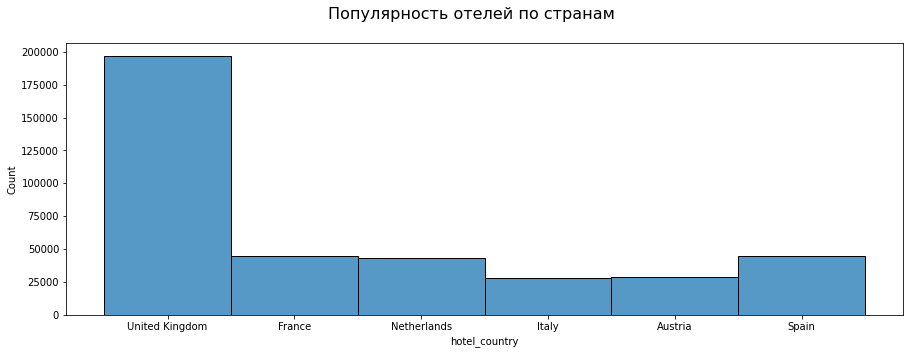

In [237]:
# Оценим распределение популярности отелей среди опрошенных
fig = plt.subplots(figsize=(15, 5))
plt.suptitle('Популярность отелей по странам', size=16)
fig = sns.histplot(
    hotels, 
    x='hotel_country')


Мы видим, что наибольшее число отзывов по отелям из Великобритании. так же посмотрим зависимость отзывов от страны

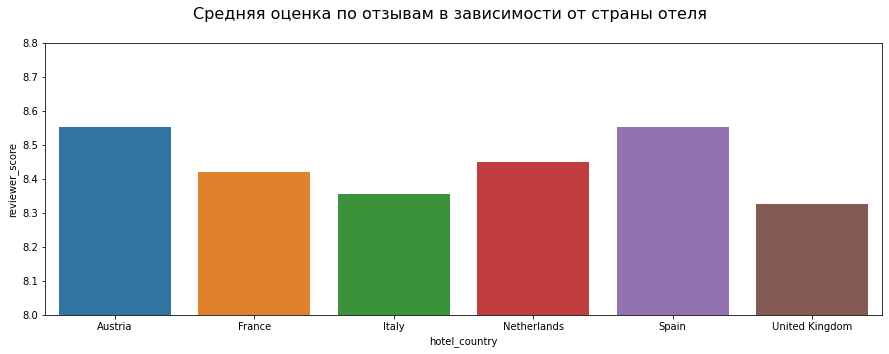

In [238]:
pivot_countries = hotels[['hotel_country', 'reviewer_score']].groupby(
    'hotel_country').mean()
fig = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от страны отеля', size=16)
bar_month = sns.barplot(
    x=pivot_countries.index, 
    y=pivot_countries['reviewer_score'])
plt.ylim(8, 8.8);

Выделим индекс из города, в дальнейшем его можно будет использовать для заполнения координат

In [239]:
def get_postcode(address):
    #Извлечение почтового индекса из строки с адресом.
    address_list = address.split()
    postcode_place = {
        'Kingdom': -4, 
        'Spain': -3, 
        'France': -3, 
        'Austria': -3, 
        'Netherlands': -4, 
        'Italy': -3
    }
    postcode = str(address_list[postcode_place[address_list[-1]]])
    
    if address_list[-1] == 'Kingdom' and postcode[-1].isalpha():
        return postcode[:-1]
    else:
        return postcode

    
# добавим почтовый индекс отеля как идентификатор района:
hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)

Теперь проанализируем страну рецензента. посмотрим какое количество стран присуствует в выборке и количество отзывов в зависимости от стран

In [240]:
print('Число стран: ', hotels['reviewer_nationality'].nunique())
hotels['reviewer_nationality'].value_counts()

Число стран:  225


 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
                               ...  
 Cook Islands                      1
 Guinea                            1
 Comoros                           1
 Anguilla                          1
 Grenada                           1
Name: reviewer_nationality, Length: 225, dtype: int64

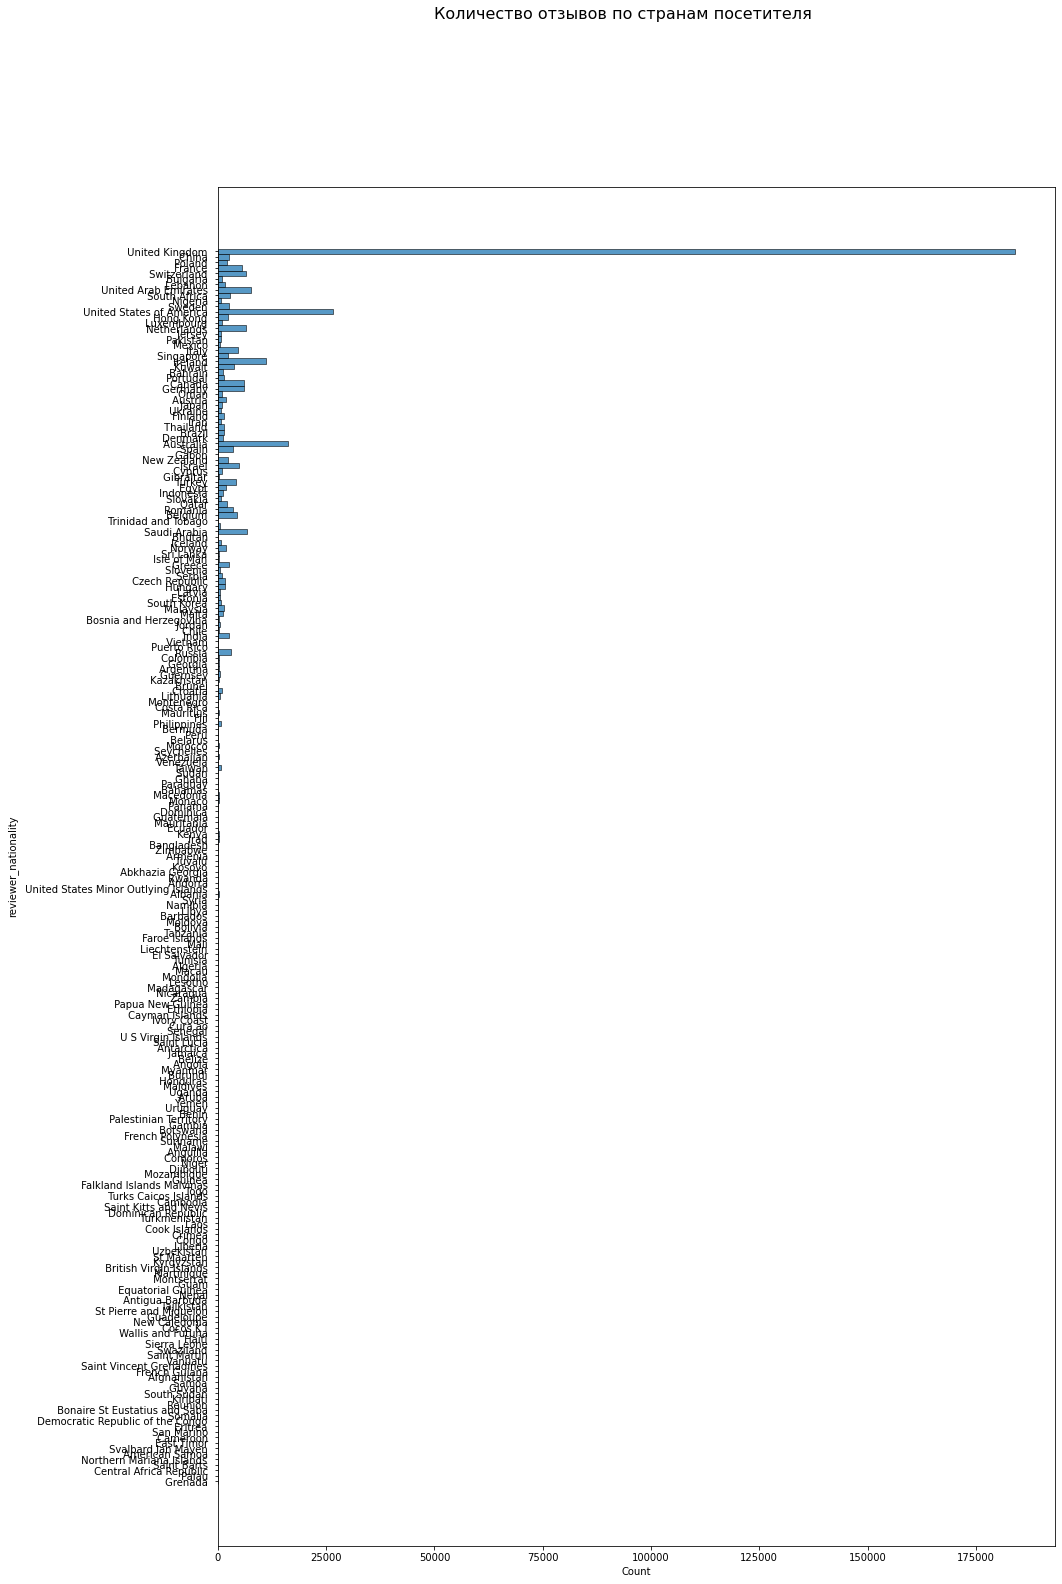

In [241]:
# Оценим количество отзывов по странам
fig = plt.subplots(figsize=(15, 25))
plt.suptitle('Количество отзывов по странам посетителя', size=16)
fig = sns.histplot(
    hotels, 
    y='reviewer_nationality',
    binwidth = 500
   )


Мы видим, что есть небольшое число стран, откуда много путешественников и все остальные. Оставим только страны путешественников, которые занимают больше 1% в общем количестве отзывов, остальные заменим на other

In [242]:
nationality = hotels['reviewer_nationality'].value_counts(normalize=True)
nationality = nationality[nationality>0.01]
display(nationality)

 United Kingdom               0.475780
 United States of America     0.068616
 Australia                    0.041983
 Ireland                      0.028764
 United Arab Emirates         0.019692
 Saudi Arabia                 0.017378
 Netherlands                  0.017084
 Switzerland                  0.016799
 Canada                       0.015470
 Germany                      0.015398
 France                       0.014330
 Israel                       0.012714
 Italy                        0.011794
 Belgium                      0.011709
 Turkey                       0.010613
Name: reviewer_nationality, dtype: float64

In [243]:
# Пометим страны респондентов как 'other', если они занимают меньше 1%
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: x if x in nationality.index else 'other'
    )
hotels['reviewer_nationality'].value_counts()

 United Kingdom               184033
other                          85822
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
 Saudi Arabia                   6722
 Netherlands                    6608
 Switzerland                    6498
 Canada                         5984
 Germany                        5956
 France                         5543
 Israel                         4918
 Italy                          4562
 Belgium                        4529
 Turkey                         4105
Name: reviewer_nationality, dtype: int64

Теперь проанализируем теги, посмотрим сколько тегов есть в отзывах и их примеры

In [244]:
hotels['len_tags'] = hotels['tags'].apply(lambda x: len(x.split(',')))

print(f'Максимальное количество тегов в 1 строке данных: {hotels["len_tags"].max()}')

print('Примеры:')
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[0])
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[10])

Максимальное количество тегов в 1 строке данных: 6
Примеры:
[' With a pet ', ' Leisure trip ', ' Solo traveler ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Group ', ' Executive Twin Room ', ' Stayed 4 nights ', ' Submitted from a mobile device ']


In [245]:
print(f'Минимальное количество тегов в 1 строке данных: {hotels["len_tags"].min()}')

Минимальное количество тегов в 1 строке данных: 1


In [199]:
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[25])
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[101])
print(hotels[hotels['len_tags'] == hotels['len_tags'].min()]['tags'].iloc[1])
print(hotels[hotels['len_tags'] == hotels['len_tags'].min()]['tags'].iloc[0])

[' With a pet ', ' Leisure trip ', ' Couple ', ' Double or Twin Room ', ' Stayed 4 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Group ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']
[' Family with young children ']
[' Couple ']


Мы видим, тут 6 типов тегов:
1. путешествие с животными или без
2. путешествие по работе / отдых
3. путешествие  одним, парой, семьей и т д
4. категория номера
5. длительность поездки
6. забронировано с мобильных устройств

In [246]:
"""Мы видим, что теги можно выделить, так как они формируются по одному шаблону, попробуем выделить теги. 
Единственная проблема - это тип номера, пока будем оставлять это единственным оставшимся тегом, остальные после преобразования будем удалять."""
# создаем новые признаки:
def get_tags(tags_string):
#Выделение 6 типов тегов по шаблонам.
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    # кодируем тип путешественника:
    reviewer_types = {'Solo traveler': 1,
                      'Couple': 2,
                      'Travelers with friends': 3,
                      'Family with young children': 4,
                      'Family with older children': 5,
                      'Group': 6}

    # формируем новые параметры:
    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 1 #  по умолчанию отдых
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''
    
    # распределяем те теги, которые есть в исходной строке:
    for tag in list(tags_list):
        if tag == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(tag)

        if tag == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(tag)

        if tag == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(tag)

        if tag == 'Leisure trip':
            tags_list.remove(tag)

        if tag in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[tag]
            tags_list.remove(tag)

        if re.fullmatch(r'Stayed\s\d+\snight\w?', tag):
            tag_count_nights = [float(s) for s in re.findall(r'-?\d+\.?\d*', tag)][0]           
            tags_list.remove(tag)
            
        if len(tags_list) > 0:
            tag_room_type = tags_list[0]

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_room_type


# формируем новые признаки:
hotels[['tag_from_mobile',
        'tag_with_pet',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(get_tags).to_list(), index=hotels.index)

print('Количество уникальных значений в новых признаках:')
hotels[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_room_type']].nunique()

Количество уникальных значений в новых признаках:


tag_from_mobile         2
tag_with_pet            2
tag_leisure_trip        2
tag_reviewer_type       6
tag_count_nights       31
tag_room_type        2335
dtype: int64

In [247]:
hotels['tag_room_type'].value_counts()

Double Room                                                26386
Standard Double Room                                       24151
Superior Double Room                                       23550
Deluxe Double Room                                         18623
Double or Twin Room                                        16824
                                                           ...  
Junior Suite with Hydromassage Shower                          1
Junior Suite Saint Honor                                       1
Suite with Garden View and Parking                             1
Superior One Bedroom Suite with Executive Lounge Access        1
Executive Double Room Non Smoking                              1
Name: tag_room_type, Length: 2335, dtype: int64

попробуем стандартизировать номера
1. добавим столбец видовой номер
2. 'Classic'
3. 'Single'
4. 'Standard', 
5. 'Superior', 
6. 'Comfort', 
7. 'Club', 
8. 'Suite'
9. 'Deluxe', 
10. 'King', 
11. 'Premier'
12. 'Double'
13. 'Other'


In [248]:
# добавим признак номера с видом:
hotels['tag_view_room'] = hotels['tag_room_type'].apply(
    lambda x: 1 if ('View' in x) | ('Panoramic' in x) else 0)

def get_room_type(tag):
    room_types = ['Classic', 'Single', 'Standard', 
                  'Superior', 'Comfort', 'Club', 'Suite', 
                  'Deluxe', 'King', 'Premier']

    for room in room_types:
        if room in tag:
            return room

    if 'Double' in tag or 'Twin' in tag:
        return 'Double'

    return 'Other'


# группируем данные с типом номера:
hotels['room_type'] = hotels['tag_room_type'].apply(get_room_type)

In [249]:
# удалим вспомогательные столбцы:
hotels.drop(['tag_room_type', 'len_tags', 'tags'], 
            axis=1, inplace=True)

<AxesSubplot:xlabel='tag_count_nights', ylabel='reviewer_score'>

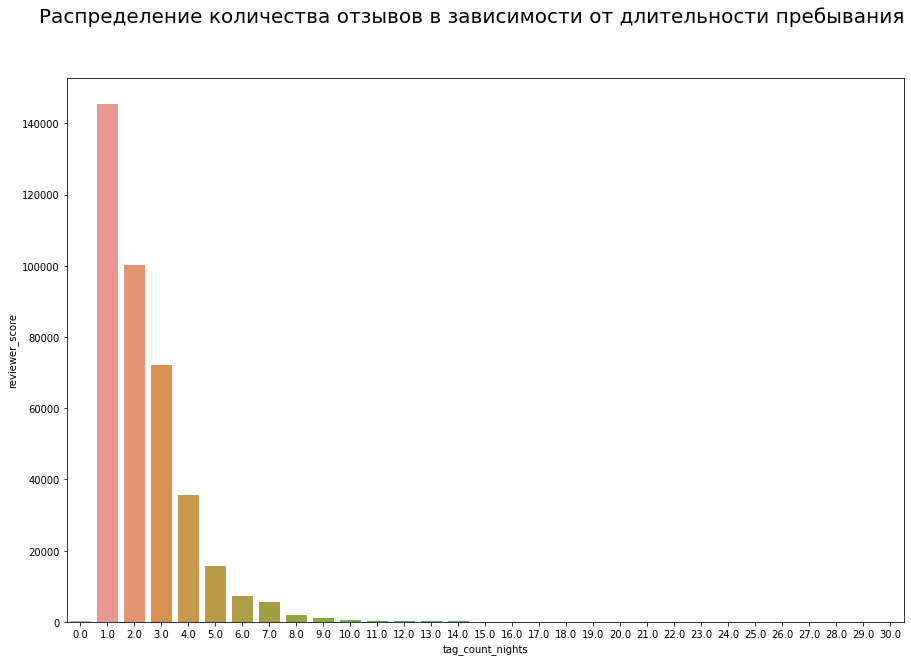

In [250]:
pivot_timeline = pd.pivot_table(
    hotels, 
    index='tag_count_nights', 
    values='reviewer_score', 
    aggfunc='count')
fig3 = plt.subplots(figsize=(15, 10))
plt.suptitle(
    'Распределение количества отзывов в зависимости от длительности пребывания', size=20)
sns.barplot(x=pivot_timeline.index, y=pivot_timeline['reviewer_score'])

(7.5, 9.0)

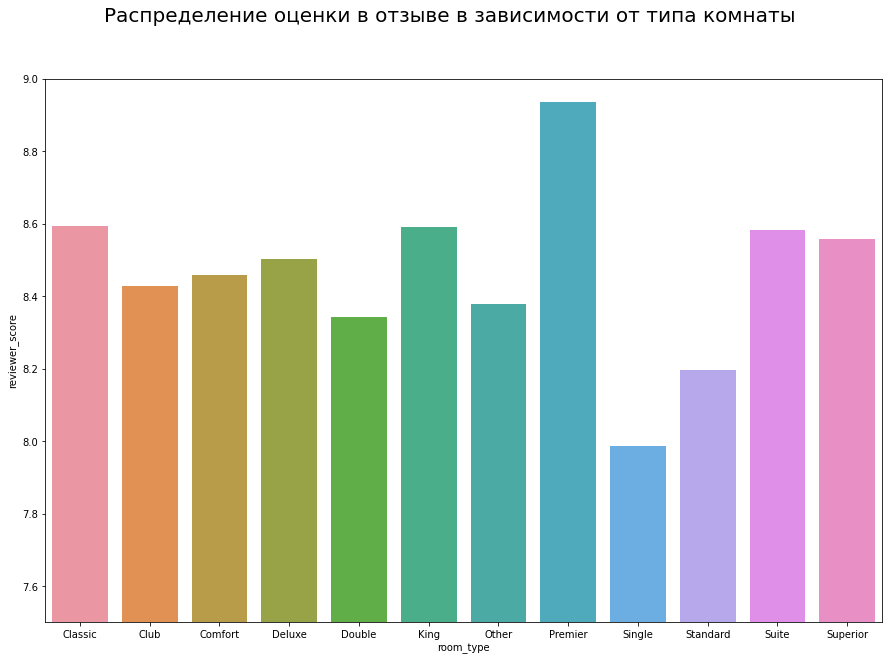

In [251]:
pivot_rooms = pd.pivot_table(
    hotels, 
    index='room_type', 
    values='reviewer_score', 
    aggfunc='mean')
fig4 = plt.subplots(figsize=(15, 10))
plt.suptitle(
    'Распределение оценки в отзыве в зависимости от типа комнаты', size=20)
sns.barplot(x=pivot_rooms.index, y=pivot_rooms['reviewer_score'])
plt.ylim(7.5, 9)

мы видим зависимость оценки от типа номера. для небольших номеров оценка в среднем ниже, чем для больших номеров.

Теперь проанализируем отзывы. посмотрим каке из них наиболее популярные.

In [252]:
print(f"Число видов позитивных отзывов: {hotels['positive_review'].nunique()}")

print(f"Число видов негативных отзывов: {hotels['negative_review'].nunique()}")

Число видов позитивных отзывов: 311737
Число видов негативных отзывов: 248828


In [253]:
# Отзывы и  частота их встречаемости
positive_df = hotels['positive_review'].value_counts()
negative_df = hotels['negative_review'].value_counts()

# Подсчет количества отзывов с частотой 100 и более раз
positive_df = positive_df[positive_df >= 100]
negative_df = negative_df[negative_df >= 100]

print('Число вариантов позитивных отывов встречающихся 100 и более раз равно:',
      positive_df.shape[0])

print('Число вариантов позитивных отывов встречающихся 100 и более раз равно:',
      negative_df.shape[0])

Число вариантов позитивных отывов встречающихся 100 и более раз равно: 43
Число вариантов позитивных отывов встречающихся 100 и более раз равно: 33


предлагаю оставить часто встречаемые отзывы и потом их закодировать, остальные отзывы пометим как other. в дальнейшем закодируем их

In [254]:
# Пометим отзывы с частотой менее 100 как 'other'
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x if x in positive_df.index else 'Other'
    )
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x if x in negative_df.index else 'Other'
    )

print('количество позитивных отзывов:',
    hotels['positive_review'].value_counts().shape[0])
print('количество негативных отывов:',
    hotels['negative_review'].value_counts().shape[0])

количество позитивных отзывов: 44
количество негативных отывов: 34


## Непрерывные признаки

В модели есть изначальный набор непрерывных признаков, которые не нужно преобразовывать, но надо будет провести нормализацию и стандартизацию этих признаков. а так же посмотреть их влияние на итоговый результат. такими признаками является
1. average_score
2. review_total_negative_word_counts
3. review_total_positive_word_counts
4. reviewer_score
5. total_number_of_reviews_reviewer_has_given 
6. total_number_of_reviews 
7. additional_number_of_scoring 
8. lat 
9. lng 

При этом мы видели. что в lat и lng есть пропускию нам нужно их заполнить, заполним их модой по указанным индексам

In [255]:
print ('количество пропущенных значений lat', hotels[hotels['lat'].isnull()].shape[0])
print ('количество пропущенных значений lng', hotels[hotels['lng'].isnull()].shape[0])

количество пропущенных значений lat 2448
количество пропущенных значений lng 2448


In [257]:
# производим замену пропущенных значений модой по индексам, в которых находятся отели
hotels['lat'] = hotels['lat'].fillna(
    hotels.groupby(['hotel_postcode'])['lat'].transform(lambda x: x.mode()[0]))
hotels['lng'] = hotels['lng'].fillna(
    hotels.groupby(['hotel_postcode'])['lng'].transform(lambda x: x.mode()[0]))
hotels[hotels['lat'].isnull()]['hotel_postcode'].value_counts()

Series([], Name: hotel_postcode, dtype: int64)

## Кодирование признаков и удаление столбцов

In [258]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

Выполним порядковое кодирование для типов комнат - будем использовать одинарное кодирование, так как признаков меньше 15
Так же у нас было 2 поля Страна и Город, по которым мы выяснили, что каждой стране у нас соответствет только один город, т е эти признаки одинаковые и мы оставим один из них. Я оставлю страну. Так как в этом признаке менее 15 значений, то можно использовать одинарное кодирование.

In [259]:
encoder = ce.OneHotEncoder(cols=['hotel_country', 'room_type']) # указываем столбец для кодирования
hotel_bin = encoder.fit_transform(hotels[['hotel_country','room_type']])
hotels = pd.concat([hotels, hotel_bin], axis=1)

Теперь закодируем оставшиеся признаки: reviewer_nationality, negative_review, positive_review, hotel_postcode.
В них более 15 значений, поэтому будем использовать двоичное кодирование для этих признаков.
Признак hotel_name кодировать не будем. пока построим модель без него. 

In [260]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality', 'negative_review', 'positive_review', 'hotel_postcode']) # указываем столбец для кодирования
data_bin = bin_encoder.fit_transform(hotels[['reviewer_nationality', 'negative_review', 'positive_review', 'hotel_postcode']])
hotels = pd.concat([hotels, data_bin], axis=1)

In [261]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 71 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

Теперь удалим оставшиеся, непреобразованные столбцы: hotel_address, review_date, hotel_name, reviewer_nationality, negative_review, positive_review, hotel_country, hotel_city, hotel_postcode, room_type

In [262]:
hotels = hotels.drop(
    ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality',
    'negative_review', 'positive_review', 'hotel_country', 
    'hotel_city', 'hotel_postcode','room_type'], 
    axis=1
    )


## Нормализация и стандартизация признаков

Нормализуем некоторые числовые признаки

In [263]:
mm_scaler = preprocessing.MinMaxScaler()

hotels['review_total_positive_word_counts']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_positive_word_counts'])),
    columns=['review_total_positive_word'])

hotels['review_total_negative_word_counts']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

hotels['total_number_of_reviews_reviewer_has_given']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['total_number_of_reviews_reviewer_has_given'])),
    columns=['total_number_of_reviews_reviewer_has_given'])

hotels['total_number_of_reviews']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['total_number_of_reviews'])),
    columns=['total_number_of_reviews'])

hotels['additional_number_of_scoring']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['additional_number_of_scoring'])),
    columns=['additional_number_of_scoring'])

## Анализ корреляции

In [264]:
hotels_corr = hotels.corr()

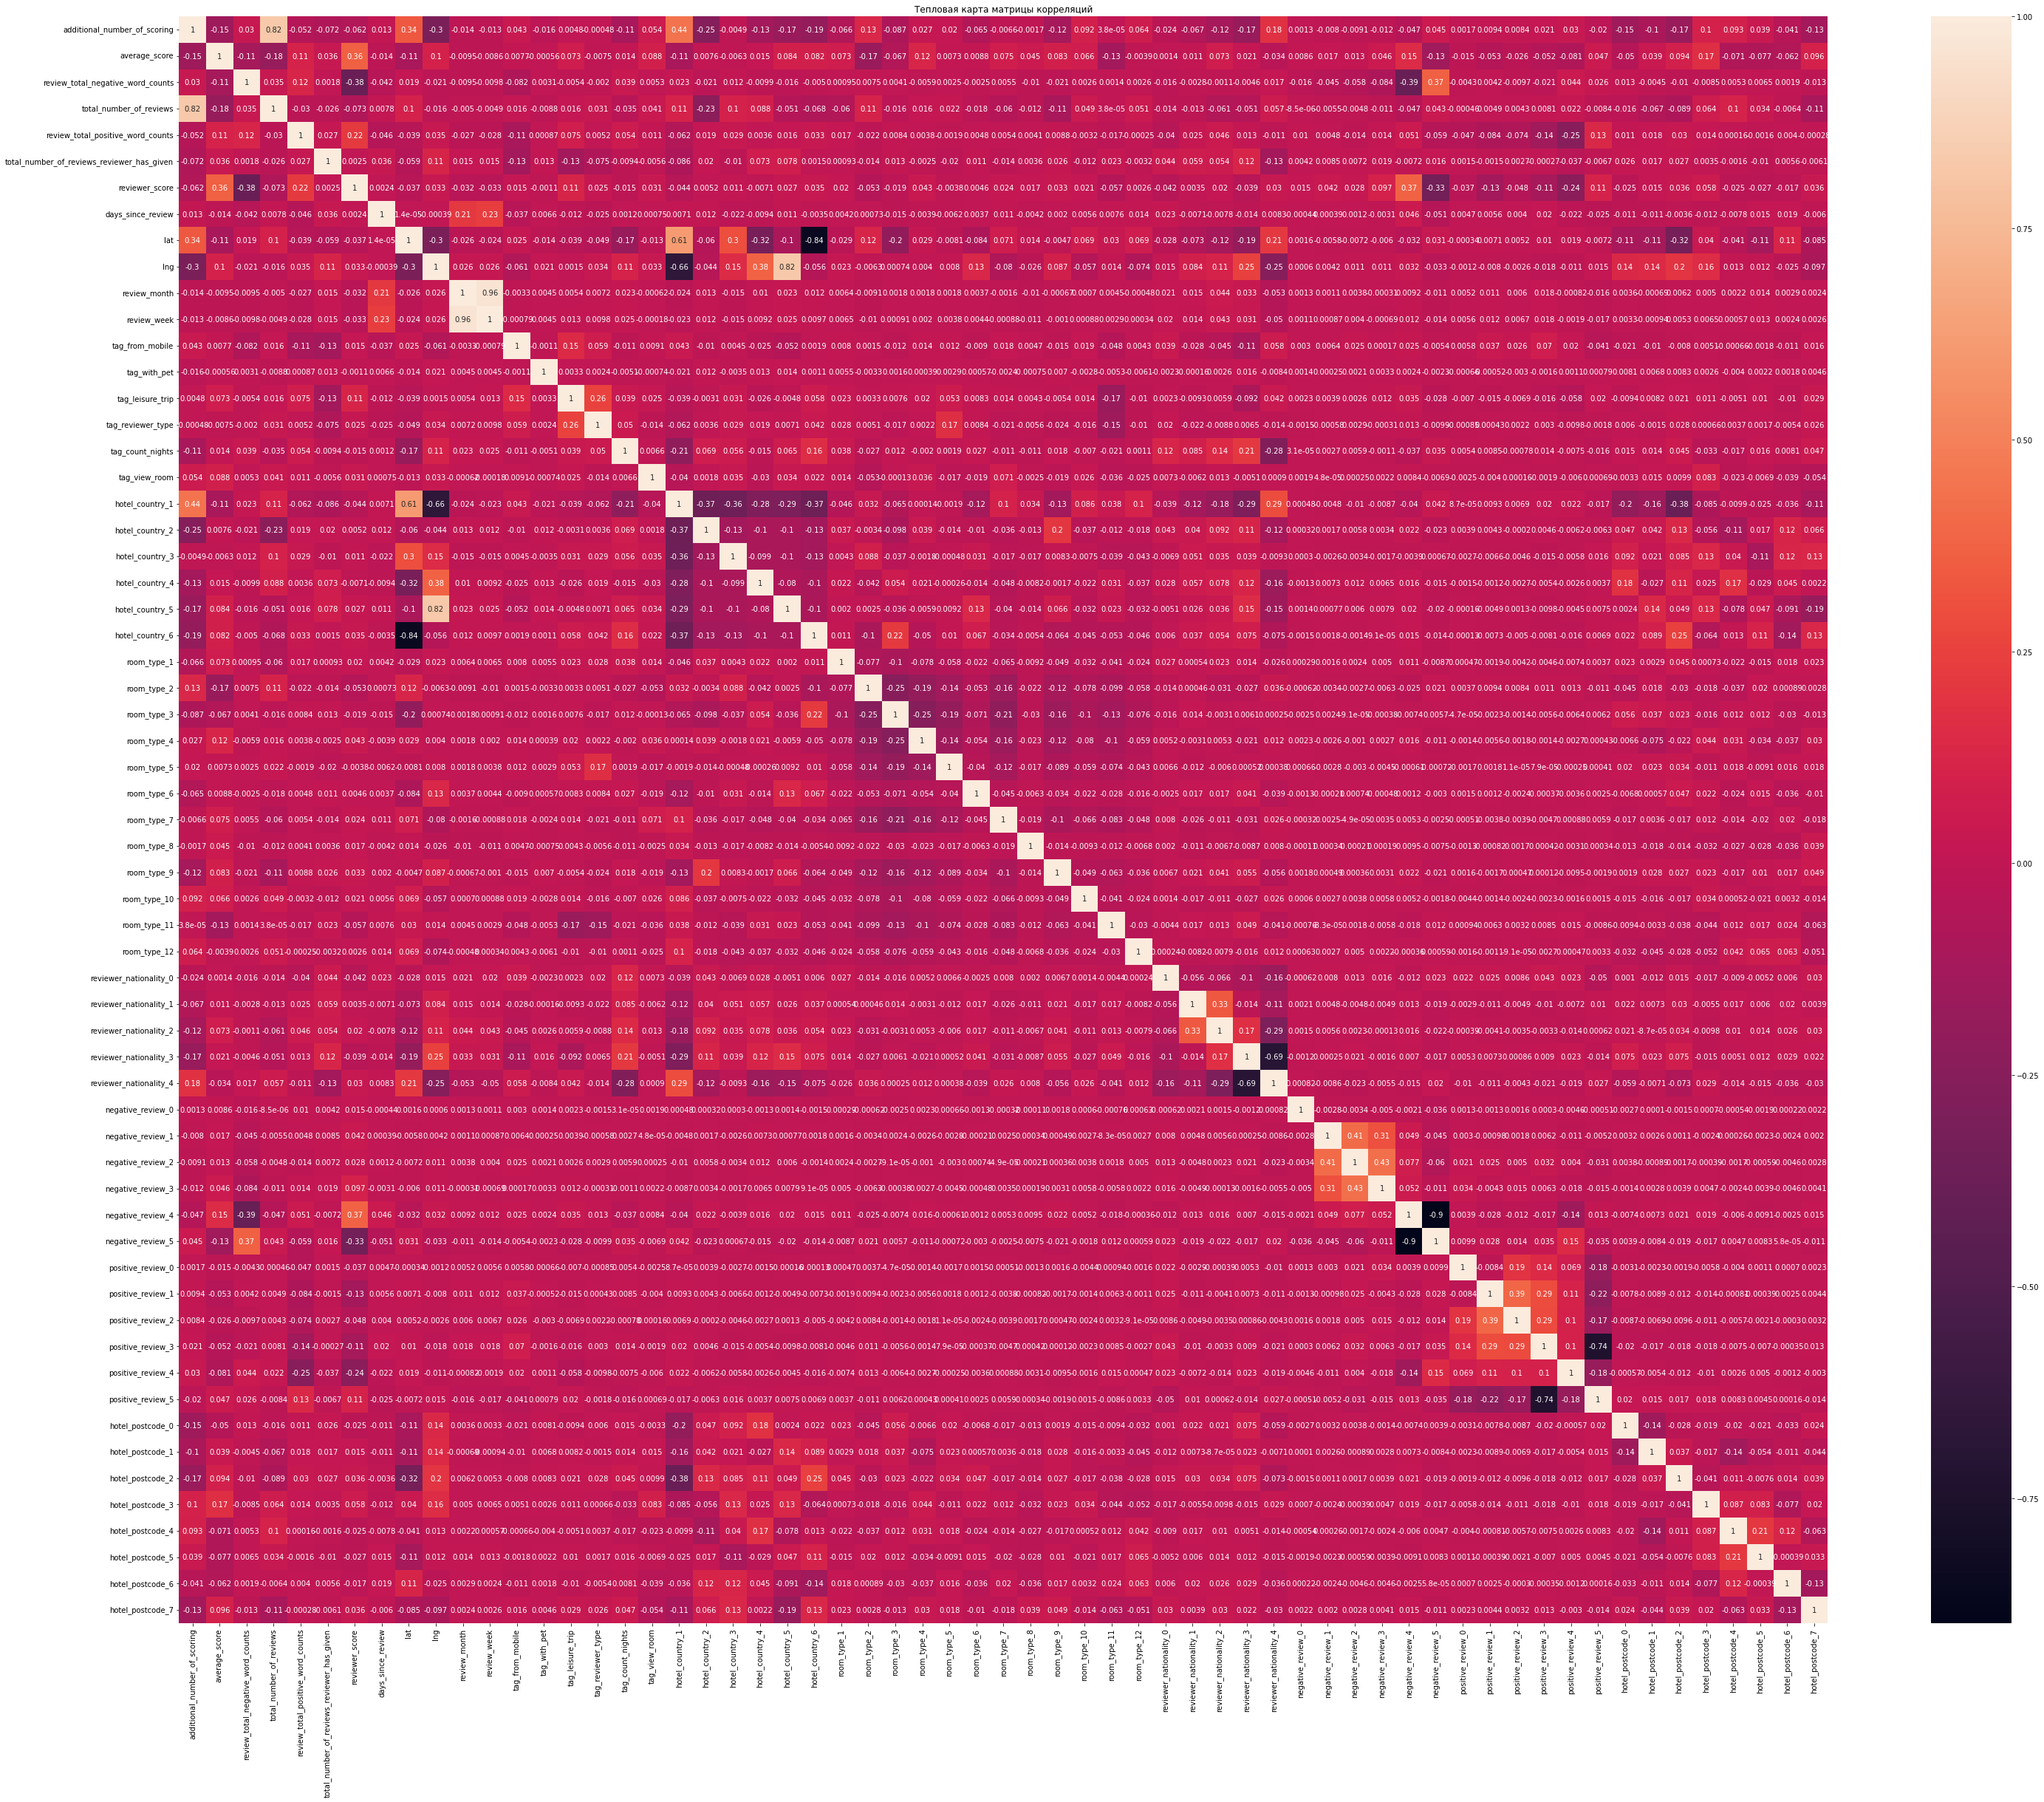

In [265]:
plt.figure(figsize=(50,40))
fig6 = sns.heatmap(hotels_corr, annot=True) # включаем отображение коэффициентов
fig6.set_title("Тепловая карта матрицы корреляций")
plt.show()

Нам нужно проверить мультиколлинеарность, удалим признаки с очень сильной корреляцией (где коэффициент корреляции +/-0.7 и выше): 
1. 'additional_number_of_scoring' и 'total_number_of_reviews'
2. 'hotel_country_6' и 'lat'
3. 'hotel_country_5' и 'lng'
4. 'review_month' и 'review_week'
5. 'negative_review_4' и 'negative_review_5'
6. 'positive_review_3' и 'positive_review_5'

нам нужно удалить один из столбцов, удалим 'additional_number_of_scoring', удалим координаты, по ним не очень высокая корреляция с результатом ('lat', 'lng'), 'review_week', 'negative_review_5', 'positive_review_5' 

In [266]:
hotels = hotels.drop(
    ['additional_number_of_scoring','lat', 'lng', 
     'review_week', 'negative_review_5', 'positive_review_5' ], 
    axis=1
    )


## Значимость признаков

сделаем разделение текущих признаков на категориальные и непрерывные, проведем проверку значимости.

In [267]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 'days_since_review', 
            'average_score']

# категориальные признаки
cat_cols = [ 'review_month', 'tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
            'tag_reviewer_type', 'tag_count_nights', 'tag_view_room', 'hotel_country_1', 'hotel_country_2', 
            'hotel_country_3', 'hotel_country_4', 'hotel_country_5', 'hotel_country_6', 'room_type_1', 
            'room_type_2', 'room_type_3', 'room_type_4', 'room_type_5', 'room_type_6', 'room_type_7', 
            'room_type_8', 'room_type_9', 'room_type_10', 'room_type_11', 'room_type_12', 'reviewer_nationality_0', 
            'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 
            'negative_review_0', 'negative_review_1', 'negative_review_2', 'negative_review_3', 'negative_review_4', 
            'positive_review_0', 'positive_review_1', 'positive_review_2', 'positive_review_3', 
            'positive_review_4', 'hotel_postcode_0', 'hotel_postcode_1', 'hotel_postcode_2', 
            'hotel_postcode_3', 'hotel_postcode_4', 'hotel_postcode_5', 'hotel_postcode_6', 'hotel_postcode_7' ]

<AxesSubplot:>

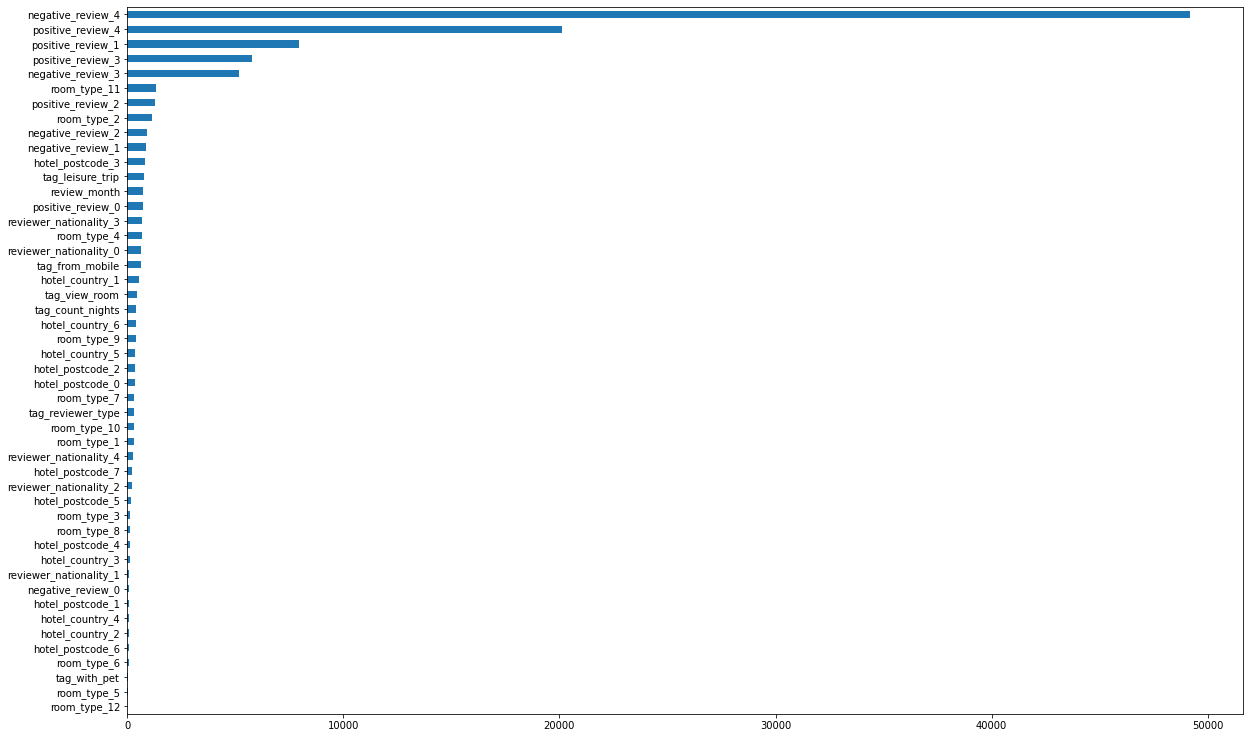

In [268]:
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
fig5 = plt.subplots(figsize=(20, 13))
imp_cat.plot(kind = 'barh')

Мы видим, что переменные reviewer_nationality_1, negative_review_0, hotel_postcode_1, hotel-country_4, hotel_country_2, hotel_postcode_6, room_type_6 - малозначимы.
так же переменные tag_with_pet, room_type_5, room_type12 - не значимы совсем, но мы дополлнительно посмотрим на них в матрице корреляций

<AxesSubplot:>

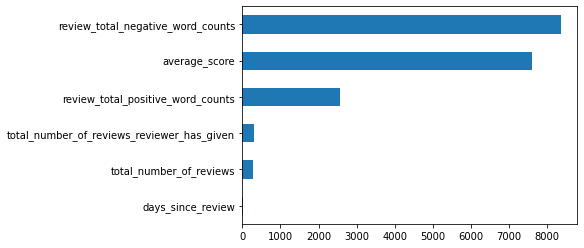

In [269]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Tак же days_since_review совсем не значима.

In [271]:
hotels = hotels.drop(
    ['days_since_review','tag_with_pet', 'room_type_5', 'room_type_12'], 
    axis=1
    )


## Построение модели

In [278]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [279]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [280]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [281]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13348720083571522
